Author- Balasubramaniam Dakshinamoorthi
Objective-Houston Power Consumption Forecasting based on Weather
Details
#Recent Texas Feb 15th- 2021 Power Outage, came to attention worldwide resulting in everyone looking for answer to what went wrong. 
#Houston was the most affected city and reported1500+ Carbon Monoxide deaths due to Texans running cars in enclosed spaces. 
#My mission is to provide insights to power companies and lawmakers about the story behind the data since the storm was forecasted in advance.
#By accurately anticipating power requirements, lawmakers and power companies can evaluate whether their production capabilities are sufficient.
#Data preparation
#Houston Power consumption hourly data in kWH from 01-06-2016 to 07-07-2020.
#Houston Weather data consists of daily Max Temp, Dew,Humitidy,Pressure,Wind,Precipitation
#Houston Power Consumption data converted to Power usage in KWH per daily 
#Combined Power Consumption KWH and Weather maximum temperature combined into one data frame 
#Subset of sliced data frame created for from 01-06-2016 to 12-31-2019

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt


# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
#from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

import sys

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, max_error,median_absolute_error, mean_squared_log_error


In [109]:
df_usage = pd.read_csv('C:/Timeseries/HoustonPowerUsage.csv')
df_weather = pd.read_csv('C:/Timeseries/HoustonWeather.csv')

In [110]:
df_usage.head()

,StartDate,PowerKWH,day_of_week,notes
0,1/6/2016 0:00,1.057,2,weekday
1,1/6/2016 1:00,1.171,2,weekday
2,1/6/2016 2:00,0.560,2,weekday
3,1/6/2016 3:00,0.828,2,weekday
4,1/6/2016 4:00,0.932,2,weekday


In [111]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [112]:

n = df_usage.shape[0]
print(n)
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = n))
df_usage['StartDate'] = p1.to_frame().index

# Date column update for 'df_weather'
m = df_weather.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
df_weather['Date'] = p2.to_frame().index

# convert the period date into timestamp
df_usage['StartDate'] = df_usage['StartDate'].apply (lambda x: x.to_timestamp())
df_usage['Date'] = pd.DatetimeIndex(df_usage['StartDate']).date

# convert the period date into timestamp
df_weather['Date'] = df_weather['Date'].apply (lambda x: x.to_timestamp())

35952


In [113]:
df_usage_daily = df_usage.groupby('Date').sum()
df_usage_daily['day_of_week'] = df_usage_daily['day_of_week'].apply(lambda x: x/24)

notes_col = df_usage.groupby('Date').first()['notes'].values
df_usage_daily['notes'] = notes_col
df_usage_daily.head()

,PowerKWH,day_of_week,notes
Date,,,
2016-06-01,29.691,2.0,weekday
2016-06-02,28.789,5.0,weekend
2016-06-03,19.247,6.0,weekend
2016-06-04,22.883,2.0,weekday
2016-06-05,25.195,4.0,weekday


In [114]:

k = df_usage_daily.shape[0]
df_weather = df_weather[0:k]
df_weather.set_index('Date', inplace=True)
df_weather.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,,
2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [115]:
df_weather.shape

(1498, 18)

In [116]:
comb_df = pd.merge(df_weather,df_usage_daily,left_index=True, right_index=True)

In [117]:
comb_df.columns

Index(['Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
       'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg',
       'Wind_min', 'Press_max', 'Press_avg', 'Press_min', 'Precipit',
       'day_of_week_x', 'PowerKWH', 'day_of_week_y', 'notes'],
      dtype='object')

In [118]:
comb_df.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,...,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_x,PowerKWH,day_of_week_y,notes
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,65,...,9.5,0,29.8,29.8,29.7,0.00,2,29.691,2.0,weekday
2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,89,...,7.8,0,29.8,29.8,29.7,4.33,5,28.789,5.0,weekend
2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,72,...,4.7,0,29.8,29.8,29.7,3.18,6,19.247,6.0,weekend
2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,85,...,7.0,0,29.8,29.7,29.7,2.37,2,22.883,2.0,weekday
2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,62,...,7.7,0,29.7,29.7,29.7,0.39,4,25.195,4.0,weekday


In [119]:
#Writing into CSV File for R- Analysis and Forecasting
comb_df.to_csv('HoustonPowerWeather.csv',index=True,header=True)

<AxesSubplot:xlabel='Date'>

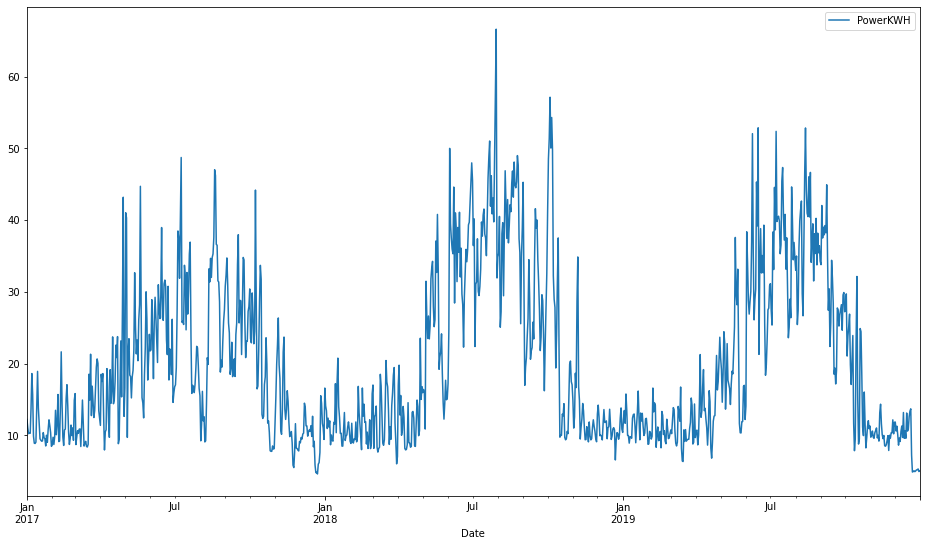

In [78]:
comb_df['PowerKWH'].loc['2017-01-01':'2019-12-31'].plot(figsize= (16,9), legend= True)

<AxesSubplot:xlabel='Date'>

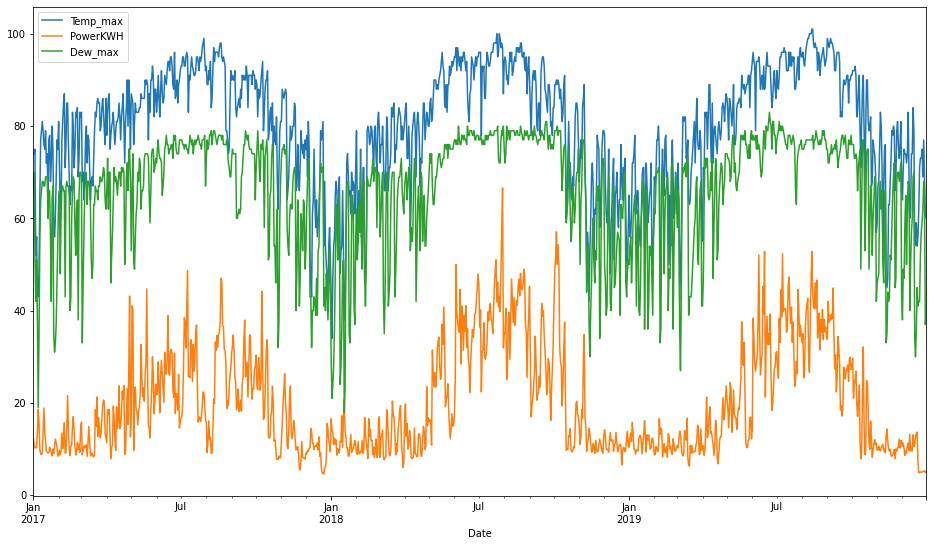

In [79]:
comb_df[['Temp_max','PowerKWH', 'Dew_max' ]].loc['2017-01-01':'2019-12-31'].plot(figsize= (16,9))

In [80]:
comb_df.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,...,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_x,PowerKWH,day_of_week_y,notes
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,65,...,9.5,0,29.8,29.8,29.7,0.00,2,29.691,2.0,weekday
2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,89,...,7.8,0,29.8,29.8,29.7,4.33,5,28.789,5.0,weekend
2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,72,...,4.7,0,29.8,29.8,29.7,3.18,6,19.247,6.0,weekend
2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,85,...,7.0,0,29.8,29.7,29.7,2.37,2,22.883,2.0,weekday
2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,62,...,7.7,0,29.7,29.7,29.7,0.39,4,25.195,4.0,weekday


In [81]:
df_short = comb_df.loc['2017-01-01':'2019-12-31']

<AxesSubplot:xlabel='Date'>

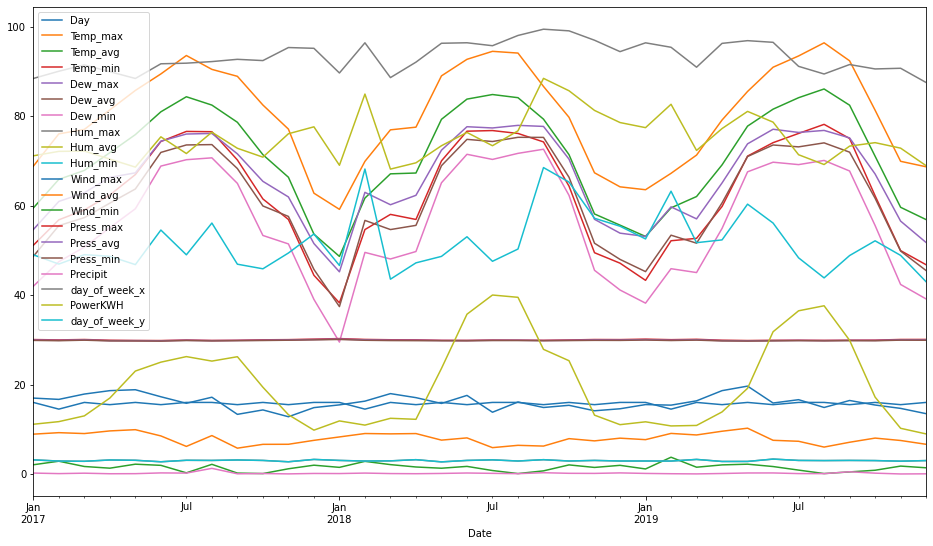

In [82]:
df_short.resample(rule= 'M').mean().plot(figsize= (16,9))

<AxesSubplot:xlabel='Date'>

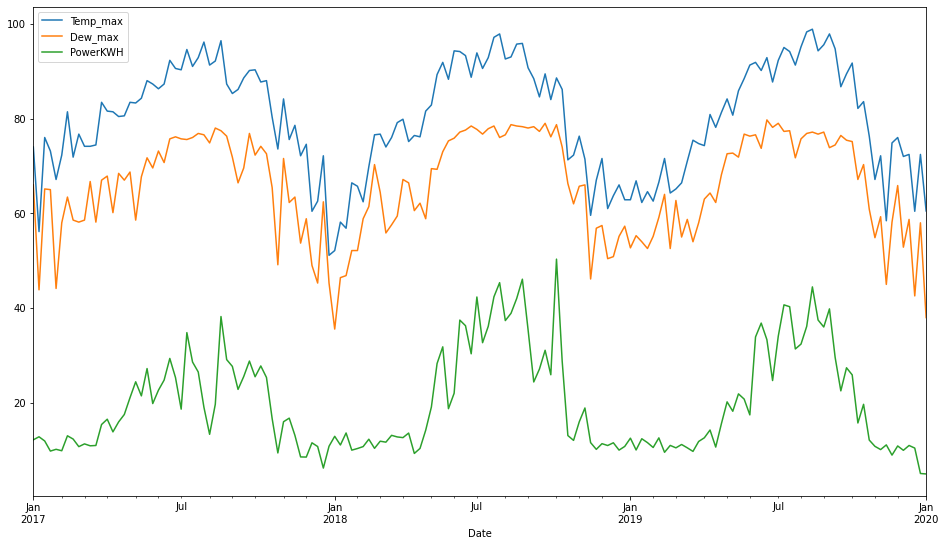

In [83]:
df_short = df_short[['Temp_max', 'Dew_max', 'PowerKWH','notes']]
df_short.resample(rule= 'W').mean().plot(figsize= (16,9))

<AxesSubplot:xlabel='Date'>

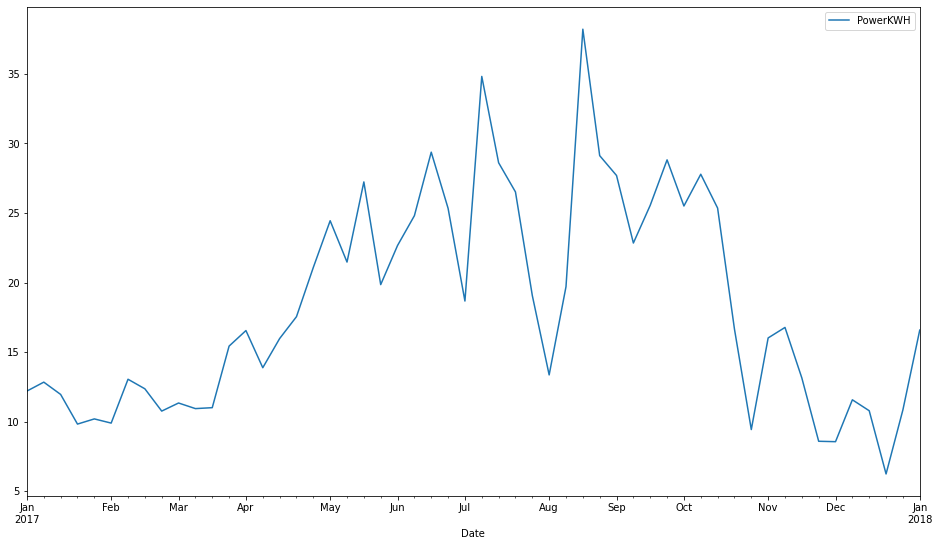

In [84]:
df_short['PowerKWH'].loc['2017-01-01': '2018-01-01'].resample(rule= 'W').mean().plot(figsize= (16,9), legend=True)

In [85]:
df_short['EWMA12'] = df_short['PowerKWH'].ewm(span=30,adjust=True).mean()
df_short['EWMA12_Temp'] = df_short['Temp_max'].ewm(span=30,adjust=True).mean()
df_short['EWMA12_Dew'] = df_short['Dew_max'].ewm(span=30,adjust=True).mean()

<AxesSubplot:xlabel='Date'>

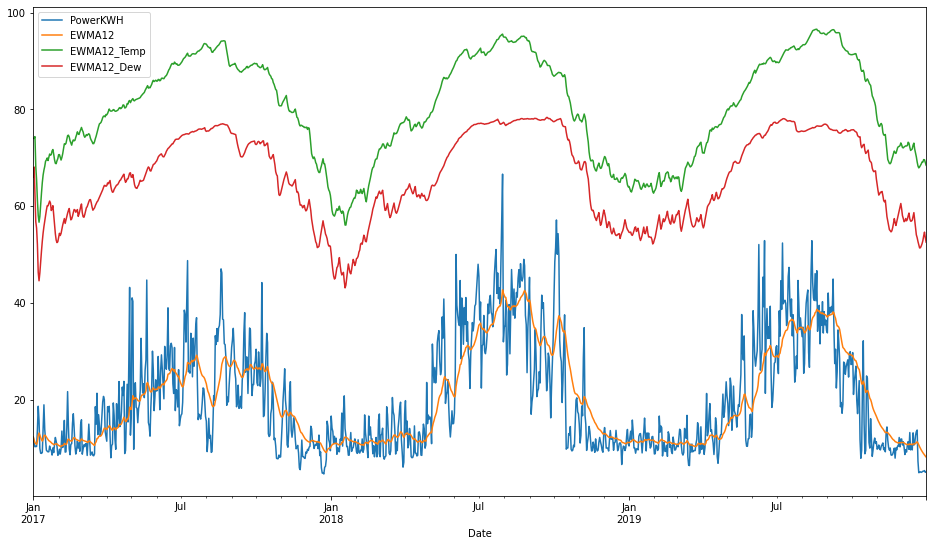

In [86]:
df_short[['PowerKWH','EWMA12', 'EWMA12_Temp', 'EWMA12_Dew']].plot(figsize= (16,9))

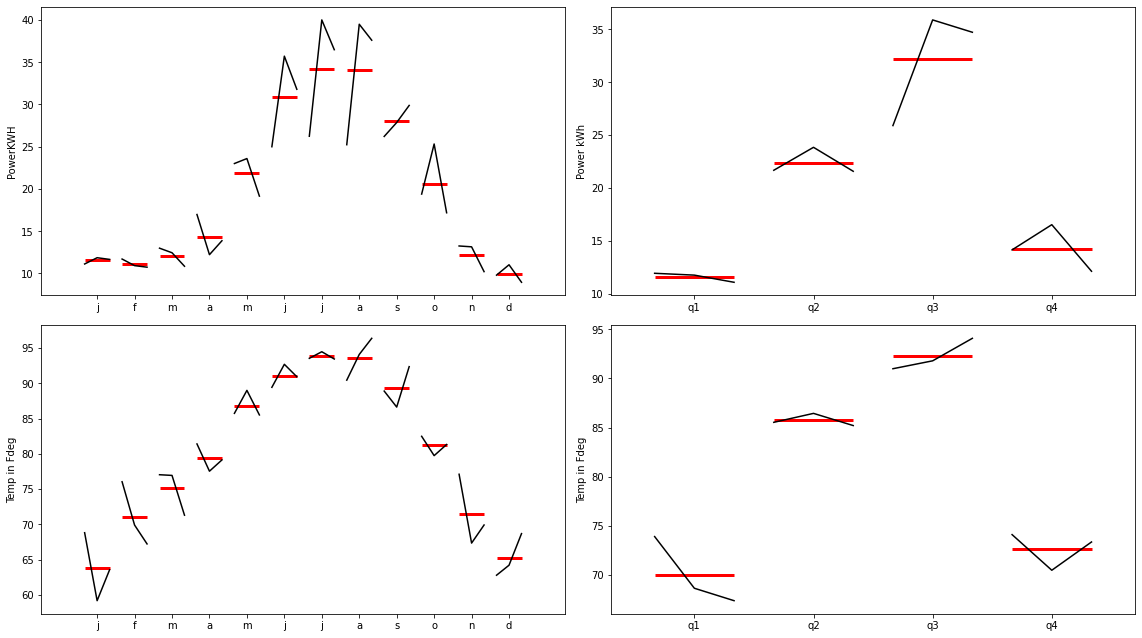

In [87]:
# plot all four graphs in one go to show the performance of temp vr 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (16,9),  squeeze=False)
#fig = plt.figure(8,5)


dfm = df_short['PowerKWH'].resample(rule='M').mean()
month_plot(dfm, ylabel= 'PowerKWH', ax =ax1);
dfq = df_short['PowerKWH'].resample(rule='Q').mean()
quarter_plot(dfq, ylabel = 'Power kWh', ax=ax2);

dftm = df_short['Temp_max'].resample(rule='M').mean()
month_plot(dftm, ylabel= 'Temp in Fdeg', ax=ax3);
dftq = df_short['Temp_max'].resample(rule='Q').mean()
quarter_plot(dftq, ylabel = 'Temp in Fdeg', ax=ax4);

fig.tight_layout(pad=1.2)


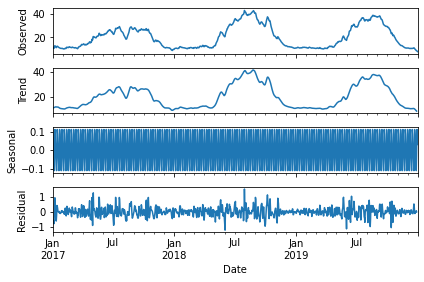

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_pwr= seasonal_decompose(df_short['EWMA12'], model='additive')
result_pwr.plot();

<AxesSubplot:xlabel='Date'>

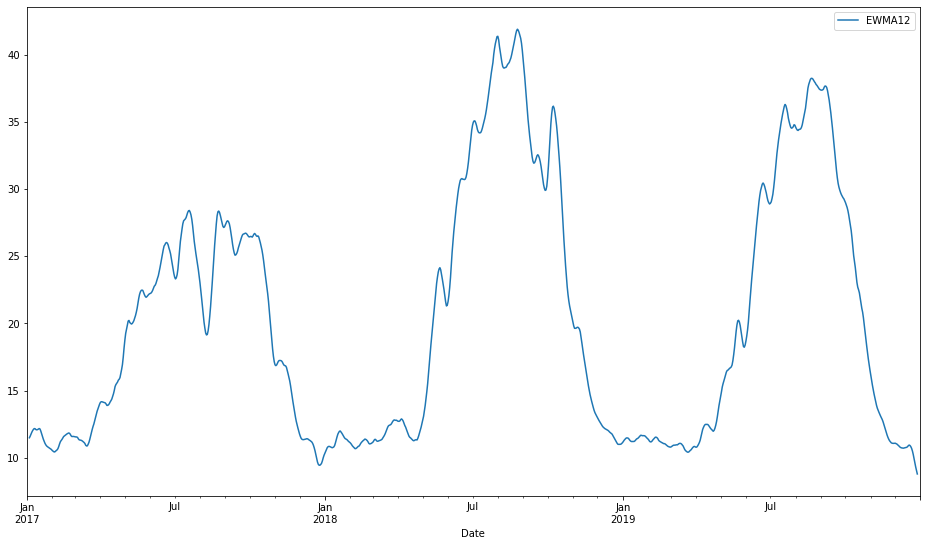

In [89]:
result_pwr.trend.plot(figsize=(16,9), legend= True)


In [90]:
## HP Filter
# Filtering the seasonality out of the data and converting this into only trend lines.
pwr_cycle, pwr_trend = hpfilter(df_short['EWMA12'],lamb=129600)
df_short['hpfilt_trend'] = pwr_trend.values

# Filtering the seasonality out of the data and converting this into only trend lines.
temp_cycle, temp_trend = hpfilter(df_short['EWMA12_Temp'],lamb=129600)
df_short['hpfilt_temp']= temp_trend.values

# Filtering the seasonality out of the data and converting this into only trend lines.
dew_cycle, dew_trend = hpfilter(df_short['EWMA12_Dew'],lamb=129600)
df_short['hpfilt_dew']= dew_trend.values

In [91]:
df_short.head()

,Temp_max,Dew_max,PowerKWH,notes,EWMA12,EWMA12_Temp,EWMA12_Dew,hpfilt_trend,hpfilt_temp,hpfilt_dew
Date,,,,,,,,,,
2017-01-01,74,66,12.200,weekend,12.200000,74.000000,66.000000,11.646508,65.564219,55.251539
2017-01-02,74,70,11.026,weekday,11.593433,74.000000,68.066667,11.626721,65.717971,55.287754
2017-01-03,75,52,10.225,weekday,11.106553,74.355794,62.350241,11.606938,65.871787,55.324053
2017-01-04,52,42,10.312,weekend,10.887625,68.195958,56.743008,11.587163,66.025797,55.360616
2017-01-05,56,51,10.280,weekday,10.749375,65.421082,55.436334,11.567397,66.180196,55.397679


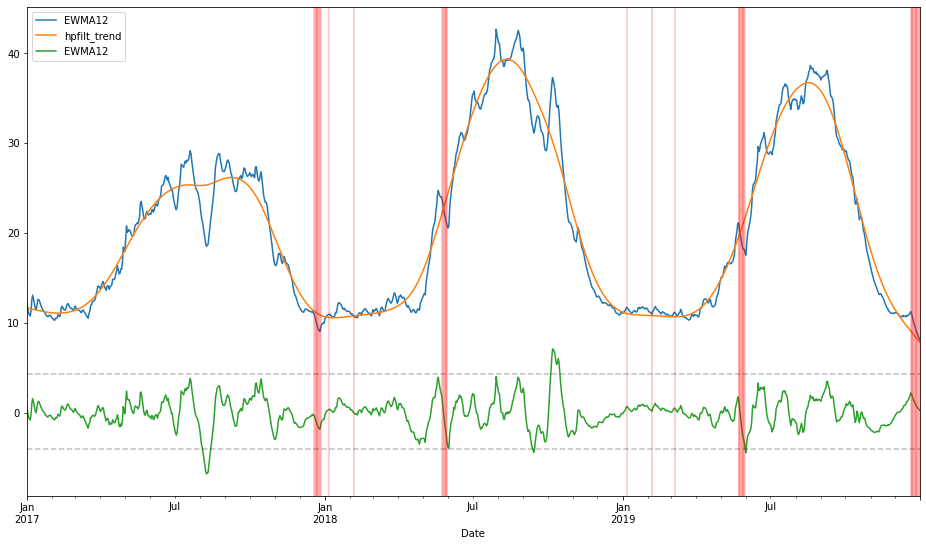

In [92]:
ax = df_short['EWMA12'].plot(figsize=(16,9), legend=True)


df_short['hpfilt_trend'].plot(figsize=(16,9), legend=True)
pwr_cycle.plot(legend=True)


for day in df_short[df_short['notes'] =='vacation'].index:
    ax.axvline(x=day, color= 'red', alpha= .25);

    
ax.axhline(y=(pwr_cycle.values.min())*.6, xmin=0, xmax=1, color= 'black', alpha= .25, ls= '--' )  
ax.axhline(y=(pwr_cycle.values.max())*.6, xmin=0, xmax=1, color= 'black', alpha= .25, ls= '--' )  

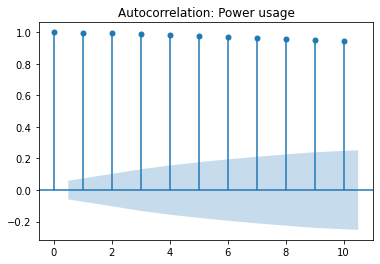

In [93]:

title = 'Autocorrelation: Power usage'
lags = 10
plot_acf(df_short['EWMA12'],title=title,lags=lags);

In [122]:
pip install neuralprophet --user

  Using cached https://files.pythonhosted.org/packages/20/52/1e00f0713b9e0e040f38834e94b6f3c3dd55b7f291e77664f27eb670abb6/neuralprophet-0.2.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/3e/2730d0effc282960dbff3cf91599ad0d8f3faedc8e75720fdf224b31ab24/tqdm-4.59.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f1/3f/da5b5aac6c43b15d32458948725069324451831a94e386a2a29dfeac18b4/pandas-1.2.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ea/51/1a869067989a0fdaf18e49f0ee3aebfcb63470525245aac7dc390cfc676a/torch_lr_finder-0.2.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


ERROR: tabula-py 1.4.1 requires distro, which is not installed.
ERROR: fbprophet 0.6 requires cmdstanpy==0.4, which is not installed.
ERROR: fbprophet 0.6 requires setuptools-git>=1.2, which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [123]:
#Using Neutral Prophet 
import pandas as pd
from neuralprophet import NeuralProphet

In [129]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    log_level=None, # Determines the logging level of the logger object
)

In [130]:
df_short.rename(columns={"Date": "ds", "Temp_max": "y"}, inplace=True)

In [133]:
df_short.head()

,y,Dew_max,PowerKWH,notes,EWMA12,EWMA12_Temp,EWMA12_Dew,hpfilt_trend,hpfilt_temp,hpfilt_dew
Date,,,,,,,,,,
2017-01-01,74,66,12.200,weekend,12.200000,74.000000,66.000000,11.646508,65.564219,55.251539
2017-01-02,74,70,11.026,weekday,11.593433,74.000000,68.066667,11.626721,65.717971,55.287754
2017-01-03,75,52,10.225,weekday,11.106553,74.355794,62.350241,11.606938,65.871787,55.324053
2017-01-04,52,42,10.312,weekend,10.887625,68.195958,56.743008,11.587163,66.025797,55.360616
2017-01-05,56,51,10.280,weekday,10.749375,65.421082,55.436334,11.567397,66.180196,55.397679


In [ ]:
#To Be Continued for Next Submission